In [3]:
%matplotlib inline
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
pd.options.display.max_rows = 200

plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('font', size=20)



# Loading Dataset

## IOT Devices

The dataset has been extracted at `ROOT_PATH`, containing the data for each IOT device. There are 9 devices in total. There are folders for each IOT device containing `benign_traffic.csv` and further two folders for `gafgyt_attacks` and `mirai_attacks`

In [9]:
ROOT_PATH = r'C:\Users\jessm\Desktop\HonoursProject\N-BaIoT_Dataset'
IOT_DEVS = [ 'Danmini_Doorbell',
             #'Ecobee_Thermostat',
             #'Ennio_Doorbell',
             'Philips_Baby_Monitor',
             #'737E_Security_Cam',
             #'838_Security_Cam',
             #'Samsung_Webcam',
             '1002_Security_Cam',
             #'1003_Security_Cam'
           ]

## Paths to CSVs
We create a python dictionary that contains all the paths to the CSVs for the respective IOT devices

In [10]:
PATHS_DICT = {}

for i in IOT_DEVS:
    PATHS_DICT[i] = {}
    print('[' + i + ']')
    iot_dir = os.path.join(ROOT_PATH, i)
    PATHS_DICT[i]['benign'] = os.path.join(iot_dir, 'benign_traffic.csv')
    print('  ', 'benign_traffic.csv')
    attacks = [ d for d in os.listdir(iot_dir)
                   if os.path.isdir( os.path.join(iot_dir, d)) ]
    for attack in attacks:
        attack_name = attack.split('_')[0]
        
        PATHS_DICT[i][attack_name] = {}
        attack_dir = os.path.join(iot_dir, attack)
        types = [ f for f in os.listdir(attack_dir)
                   if os.path.isfile( os.path.join(attack_dir, f)) ]
        print('  ', attack_name, ': ', types)
        for t in types:
            type_name = t.split('.')[0]
            PATHS_DICT[i][attack_name][type_name] = os.path.join(attack_dir,t)

[Danmini_Doorbell]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[Philips_Baby_Monitor]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[1002_Security_Cam]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']


## Loading CSVs into Pandas
We will create pandas dataframe for each botnet attack on each IOT device. For each datafram we will combine the attack traffic with the benign traffic add the following two columns:
- `traffic_type` : benign or attack (0 or 1)
- `attack_type`  : type of attack e.g, ack, scan etc.

In [11]:
nbaiot_dict = {}
for iot_dev in PATHS_DICT:
    nbaiot_dict[iot_dev] = {}
    b_df = pd.read_csv(PATHS_DICT[iot_dev]['benign'])
    b_df['traffic_type'] = 'benign'
    b_df['attack_type'] = 'benign'
    for botnet in [ b for b in PATHS_DICT[iot_dev] if b != 'benign']:
        nbaiot_dict[iot_dev][botnet] = pd.DataFrame()
        nbaiot_dict[iot_dev][botnet] = pd.concat([nbaiot_dict[iot_dev][botnet], b_df])
        for attack in PATHS_DICT[iot_dev][botnet]:
            a_df = pd.read_csv(PATHS_DICT[iot_dev][botnet][attack])
            a_df['traffic_type'] = 'attack'
            a_df['attack_type'] = attack
            nbaiot_dict[iot_dev][botnet] = pd.concat([nbaiot_dict[iot_dev][botnet], a_df])


In [12]:
for k in nbaiot_dict:
    print(k)
    for b in nbaiot_dict[k]:
        print('  ',b,':','<benign+attack>')

Danmini_Doorbell
   gafgyt : <benign+attack>
   mirai : <benign+attack>
Philips_Baby_Monitor
   gafgyt : <benign+attack>
   mirai : <benign+attack>
1002_Security_Cam
   gafgyt : <benign+attack>
   mirai : <benign+attack>


# Modeling

### Pre processing
Convert the target column `traffic_type` to integer 0 = benigh, 1 = attack 

In [13]:
for dev in nbaiot_dict:
    for botnet in nbaiot_dict[dev]:
        print(dev,botnet)
        nbaiot = nbaiot_dict[dev][botnet]

        nbaiot.loc[ nbaiot['traffic_type']=='attack','traffic_type' ]=1
        nbaiot.loc[ nbaiot['traffic_type']=='benign','traffic_type' ]=0
        nbaiot['traffic_type'] = nbaiot['traffic_type'].astype(int)
        nbaiot = nbaiot.drop(['attack_type'], axis=1)
        
        nbaiot_dict[dev][botnet] = nbaiot

Danmini_Doorbell gafgyt
Danmini_Doorbell mirai
Philips_Baby_Monitor gafgyt
Philips_Baby_Monitor mirai
1002_Security_Cam gafgyt
1002_Security_Cam mirai


### Classifiers and training functions

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Main Loop

In [15]:
classfiers = {
    'KNN' : KNeighborsClassifier(),
    'RFR' : RandomForestClassifier(),
    'DTR' : DecisionTreeClassifier(),
    'ADB' : AdaBoostClassifier(),
    
}

all_results = [
    ['DEVICE','BOTNET', 'CLASSIFIER','TRAIN-SIZE-A', 'TEST-SIZE-B',  'ACCURACY', 'PRECISION', 'RECALL', 'F1-SCORE', 'FALSE-P', 'FALSE-N' ]
]



for dev in nbaiot_dict:
    for botnet in nbaiot_dict[dev]:
        nbaiot = nbaiot_dict[dev][botnet]
        
        print("================", dev, "/", botnet, "================")

        for train_attack_count in [ 
            10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 200000 ]:
            
            df_size = len(nbaiot.index)
            df_attack_count = len(nbaiot[ nbaiot['traffic_type'] == 1].index)
            df_benign_count = len(nbaiot[ nbaiot['traffic_type'] == 0].index)
            
            train_attack_pct = train_attack_count / df_attack_count
            train_benign_count = round(df_benign_count * train_attack_pct)
            
            df_attack = nbaiot[ nbaiot['traffic_type'] == 1]
            df_train_attack = df_attack.sample(train_attack_count)
            df_test_attack = df_attack.drop(df_train_attack.index)
            
            df_benign = nbaiot[ nbaiot['traffic_type'] == 0]
            df_train_benign = df_benign.sample(train_benign_count)
            df_test_benign = df_benign.drop(df_train_benign.index)
            
            df_train = pd.concat([ df_train_attack, df_train_benign ])
            df_test  = pd.concat([ df_test_attack,  df_test_benign  ]) 
            
            print('-----------------------------------------')            
            print('df_size =',df_size)
            print('df_attack_count =',df_attack_count)
            print('df_benign_count =',df_benign_count)
            print('train_attack_pct =',round(train_attack_pct,5))
            print('train_attack_count =',train_attack_count)
            print('train_benign_count =',train_benign_count)
            print('size of df_train =',len(df_train.index))
            print('size of df_test =',len(df_test.index))
            print('-----------------------------------------')
            print('')
            
            X_train = df_train.drop([ "traffic_type" ], axis=1)
            y_train = df_train["traffic_type"]
            
            X_test = df_test.drop([ "traffic_type" ], axis=1)
            y_test = df_test["traffic_type"]
            
            for clf_name in classfiers:
                
                clf = classfiers[clf_name]
                
                clf.fit(X_train, y_train)
                
                y_preds = clf.predict(X_test)

                clrp = classification_report(y_test, y_preds, output_dict=True)
                conf_mat = confusion_matrix(y_test, y_preds)
                fp = conf_mat[0][1]
                fn = conf_mat[1][0]

                res = [
                    dev,
                    botnet,
                    clf_name,
                    
                    train_attack_count,
                    train_benign_count,
                    
                    round(clrp['accuracy'],4),
                    round(clrp['macro avg']['precision'],4),
                    round(clrp['macro avg']['recall'],4),
                    round(clrp['macro avg']['f1-score'],4),
                    fp,
                    fn
                ]
                print(res)
                all_results.append(res)
                print("")

================ Danmini_Doorbell / gafgyt ================
-----------------------------------------
df_size = 366198
df_attack_count = 316650
df_benign_count = 49548
train_attack_pct = 3e-05
train_attack_count = 10
train_benign_count = 2
size of df_train = 12
size of df_test = 366155
-----------------------------------------



C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['Danmini_Doorbell', 'gafgyt', 'KNN', 10, 2, 0.8647, 0.4323, 0.5, 0.4637, 49546, 0]

['Danmini_Doorbell', 'gafgyt', 'RFR', 10, 2, 0.9674, 0.9714, 0.8873, 0.9236, 11023, 926]

['Danmini_Doorbell', 'gafgyt', 'DTR', 10, 2, 0.9583, 0.9634, 0.8553, 0.8995, 14162, 1103]

['Danmini_Doorbell', 'gafgyt', 'ADB', 10, 2, 0.9673, 0.9712, 0.8872, 0.9235, 11027, 938]

-----------------------------------------
df_size = 366198
df_attack_count = 316650
df_benign_count = 49548
train_attack_pct = 0.00016
train_attack_count = 50
train_benign_count = 8
size of df_train = 58
size of df_test = 366015
-----------------------------------------

['Danmini_Doorbell', 'gafgyt', 'KNN', 50, 8, 0.9937, 0.9964, 0.9766, 0.9862, 2316, 0]

['Danmini_Doorbell', 'gafgyt', 'RFR', 50, 8, 0.996, 0.9885, 0.9944, 0.9914, 385, 1097]

['Danmini_Doorbell', 'gafgyt', 'DTR', 50, 8, 0.9914, 0.9858, 0.9774, 0.9815, 2077, 1064]

['Danmini_Doorbell', 'gafgyt', 'ADB', 50, 8, 0.9962, 0.9881, 0.9958, 0.9919, 239, 1160]

------------------

C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['Danmini_Doorbell', 'mirai', 'KNN', 10, 1, 0.9294, 0.4647, 0.5, 0.4817, 49547, 0]

['Danmini_Doorbell', 'mirai', 'RFR', 10, 1, 0.9965, 0.998, 0.9751, 0.9862, 2469, 10]

['Danmini_Doorbell', 'mirai', 'DTR', 10, 1, 0.9902, 0.9393, 0.9948, 0.9651, 0, 6844]

['Danmini_Doorbell', 'mirai', 'ADB', 10, 1, 0.9902, 0.9393, 0.9948, 0.9651, 0, 6844]

-----------------------------------------
df_size = 701648
df_attack_count = 652100
df_benign_count = 49548
train_attack_pct = 8e-05
train_attack_count = 50
train_benign_count = 4
size of df_train = 54
size of df_test = 701446
-----------------------------------------

['Danmini_Doorbell', 'mirai', 'KNN', 50, 4, 0.9734, 0.8711, 0.9593, 0.9095, 2830, 15845]

['Danmini_Doorbell', 'mirai', 'RFR', 50, 4, 0.9999, 0.9995, 1.0, 0.9997, 0, 51]

['Danmini_Doorbell', 'mirai', 'DTR', 50, 4, 0.9999, 0.9995, 1.0, 0.9997, 0, 51]

['Danmini_Doorbell', 'mirai', 'ADB', 50, 4, 0.9999, 0.9995, 1.0, 0.9997, 0, 51]

-----------------------------------------
df_size = 701

['Philips_Baby_Monitor', 'gafgyt', 'KNN', 500, 280, 0.9894, 0.9904, 0.9866, 0.9884, 4114, 1044]

['Philips_Baby_Monitor', 'gafgyt', 'RFR', 500, 280, 0.9974, 0.9968, 0.9976, 0.9972, 269, 985]

['Philips_Baby_Monitor', 'gafgyt', 'DTR', 500, 280, 0.9961, 0.9958, 0.9958, 0.9958, 942, 933]

['Philips_Baby_Monitor', 'gafgyt', 'ADB', 500, 280, 0.9964, 0.9965, 0.9956, 0.996, 1266, 506]

-----------------------------------------
df_size = 487963
df_attack_count = 312723
df_benign_count = 175240
train_attack_pct = 0.0032
train_attack_count = 1000
train_benign_count = 560
size of df_train = 1560
size of df_test = 483856
-----------------------------------------

['Philips_Baby_Monitor', 'gafgyt', 'KNN', 1000, 560, 0.9904, 0.9913, 0.988, 0.9896, 3643, 997]

['Philips_Baby_Monitor', 'gafgyt', 'RFR', 1000, 560, 0.9987, 0.9987, 0.9985, 0.9986, 407, 219]

['Philips_Baby_Monitor', 'gafgyt', 'DTR', 1000, 560, 0.997, 0.9975, 0.9961, 0.9968, 1269, 168]

['Philips_Baby_Monitor', 'gafgyt', 'ADB', 1000, 560,

-----------------------------------------
df_size = 785954
df_attack_count = 610714
df_benign_count = 175240
train_attack_pct = 0.01637
train_attack_count = 10000
train_benign_count = 2869
size of df_train = 12869
size of df_test = 743905
-----------------------------------------

['Philips_Baby_Monitor', 'mirai', 'KNN', 10000, 2869, 0.9919, 0.9939, 0.9834, 0.9885, 5593, 432]

['Philips_Baby_Monitor', 'mirai', 'RFR', 10000, 2869, 0.9999, 0.9999, 1.0, 0.9999, 0, 43]

['Philips_Baby_Monitor', 'mirai', 'DTR', 10000, 2869, 0.9999, 0.9999, 0.9998, 0.9999, 43, 31]

['Philips_Baby_Monitor', 'mirai', 'ADB', 10000, 2869, 0.9997, 0.9996, 0.9997, 0.9996, 83, 109]

-----------------------------------------
df_size = 785954
df_attack_count = 610714
df_benign_count = 175240
train_attack_pct = 0.08187
train_attack_count = 50000
train_benign_count = 14347
size of df_train = 64347
size of df_test = 598054
-----------------------------------------

['Philips_Baby_Monitor', 'mirai', 'KNN', 50000, 14347, 

C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['1002_Security_Cam', 'gafgyt', 'KNN', 10, 2, 0.8668, 0.4334, 0.5, 0.4643, 46583, 0]

['1002_Security_Cam', 'gafgyt', 'RFR', 10, 2, 0.9712, 0.979, 0.8957, 0.9318, 9656, 413]

['1002_Security_Cam', 'gafgyt', 'DTR', 10, 2, 0.9668, 0.9701, 0.8838, 0.9209, 10681, 946]

['1002_Security_Cam', 'gafgyt', 'ADB', 10, 2, 0.9473, 0.8955, 0.8702, 0.8822, 10950, 7468]

-----------------------------------------
df_size = 349808
df_attack_count = 303223
df_benign_count = 46585
train_attack_pct = 0.00016
train_attack_count = 50
train_benign_count = 8
size of df_train = 58
size of df_test = 349625
-----------------------------------------

['1002_Security_Cam', 'gafgyt', 'KNN', 50, 8, 0.986, 0.9921, 0.9475, 0.9683, 4886, 0]

['1002_Security_Cam', 'gafgyt', 'RFR', 50, 8, 0.9934, 0.9869, 0.9845, 0.9857, 1293, 1011]

['1002_Security_Cam', 'gafgyt', 'DTR', 50, 8, 0.9842, 0.9897, 0.9417, 0.964, 5414, 123]

['1002_Security_Cam', 'gafgyt', 'ADB', 50, 8, 0.9942, 0.9866, 0.9885, 0.9875, 905, 1111]

-------------

C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['1002_Security_Cam', 'mirai', 'KNN', 10, 1, 0.9168, 0.4584, 0.5, 0.4783, 46584, 0]

['1002_Security_Cam', 'mirai', 'RFR', 10, 1, 0.9267, 0.963, 0.5597, 0.5874, 41022, 0]

['1002_Security_Cam', 'mirai', 'DTR', 10, 1, 0.9319, 0.9654, 0.5909, 0.636, 38113, 0]

['1002_Security_Cam', 'mirai', 'ADB', 10, 1, 0.9976, 0.9858, 0.9987, 0.9921, 0, 1359]

-----------------------------------------
df_size = 559833
df_attack_count = 513248
df_benign_count = 46585
train_attack_pct = 0.0001
train_attack_count = 50
train_benign_count = 5
size of df_train = 55
size of df_test = 559626
-----------------------------------------

['1002_Security_Cam', 'mirai', 'KNN', 50, 5, 0.9907, 0.9944, 0.9445, 0.9679, 5161, 53]

['1002_Security_Cam', 'mirai', 'RFR', 50, 5, 0.9957, 0.9951, 0.9767, 0.9857, 2150, 253]

['1002_Security_Cam', 'mirai', 'DTR', 50, 5, 0.9961, 0.9958, 0.9787, 0.9871, 1969, 204]

['1002_Security_Cam', 'mirai', 'ADB', 50, 5, 0.9961, 0.9958, 0.9787, 0.9871, 1969, 204]

----------------------------

In [16]:
res_df =pd.DataFrame(all_results, index=None)

res_df, res_df.columns = res_df[1:] , res_df.iloc[0]

res_df

,DEVICE,BOTNET,CLASSIFIER,TRAIN-SIZE-A,TEST-SIZE-B,ACCURACY,PRECISION,RECALL,F1-SCORE,FALSE-P,FALSE-N
1,Danmini_Doorbell,gafgyt,KNN,10,2,0.8647,0.4323,0.5,0.4637,49546,0
2,Danmini_Doorbell,gafgyt,RFR,10,2,0.9674,0.9714,0.8873,0.9236,11023,926
3,Danmini_Doorbell,gafgyt,DTR,10,2,0.9583,0.9634,0.8553,0.8995,14162,1103
4,Danmini_Doorbell,gafgyt,ADB,10,2,0.9673,0.9712,0.8872,0.9235,11027,938
5,Danmini_Doorbell,gafgyt,KNN,50,8,0.9937,0.9964,0.9766,0.9862,2316,0
...,...,...,...,...,...,...,...,...,...,...,...
236,1002_Security_Cam,mirai,ADB,100000,9077,1.0,1.0,1.0,1.0,0,1
237,1002_Security_Cam,mirai,KNN,200000,18153,0.9947,0.9957,0.9901,0.9929,539,67
238,1002_Security_Cam,mirai,RFR,200000,18153,1.0,1.0,1.0,1.0,0,1
239,1002_Security_Cam,mirai,DTR,200000,18153,0.9999,1.0,0.9999,0.9999,6,0


In [17]:
# Write to csv
res_csv = res_df.to_csv(index=False)

print(res_csv, file=open('07_results.csv', 'w'))


### Load results from CSV

In [18]:
res_df = pd.read_csv('02_results.csv')

res_df = res_df[['DEVICE', 'BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'FALSE-P', 'FALSE-N' ]]

res_df

,DEVICE,BOTNET,CLASSIFIER,ACCURACY,PRECISION,FALSE-P,FALSE-N
0,Danmini_Doorbell,gafgyt,KNN,0.998378,0.995824,69,127
1,Danmini_Doorbell,gafgyt,RFR,0.999975,0.999934,1,2
2,Danmini_Doorbell,gafgyt,DTR,0.999959,0.999925,3,2
3,Danmini_Doorbell,gafgyt,ADB,0.999975,0.999909,0,3
4,Danmini_Doorbell,mirai,KNN,0.998609,0.993935,133,189
5,Danmini_Doorbell,mirai,RFR,0.999996,0.999969,0,1
6,Danmini_Doorbell,mirai,DTR,0.999987,0.999908,0,3
7,Danmini_Doorbell,mirai,ADB,0.999987,0.999908,0,3
8,Ecobee_Thermostat,gafgyt,KNN,0.998783,0.995446,95,35
9,Ecobee_Thermostat,gafgyt,RFR,0.999963,0.999760,2,2


In [19]:
res_df.set_index(['DEVICE', 'BOTNET', 'CLASSIFIER'], inplace=True)
res_df

ACCURACY  PRECISION  FALSE-P  FALSE-N
DEVICE            BOTNET CLASSIFIER                                       
Danmini_Doorbell  gafgyt KNN         0.998378   0.995824       69      127
                         RFR         0.999975   0.999934        1        2
                         DTR         0.999959   0.999925        3        2
                         ADB         0.999975   0.999909        0        3
                  mirai  KNN         0.998609   0.993935      133      189
                         RFR         0.999996   0.999969        0        1
                         DTR         0.999987   0.999908        0        3
                         ADB         0.999987   0.999908        0        3
Ecobee_Thermostat gafgyt KNN         0.998783   0.995446       95       35
                         RFR         0.999963   0.999760        2        2
                         DTR         0.999953   0.999534        1        4
                         ADB         0.999981   0.999990        2        0
                  mirai  KNN         0.999267   0.996645      101       26
                         RFR         0.999988   0.999769        0        2
                         DTR         0.999988   0.999769        0        2
                         ADB         0.999994   0.999885        0        1
Ennio_Doorbell    gafgyt KNN         0.998057   0.993740       75      153
                         RFR         0.999957   0.999942        4        1
                         DTR         0.999966   0.999913        2        2
                         ADB         0.999923   0.999889        7        2
B120N10_Baby_Mon  gafgyt KNN         0.998168   0.997561       26      269
                         RFR         0.999950   0.999935        1        7
                         DTR         0.999863   0.999840        8       14
                         ADB         0.999950   0.999931        0        8
                  mirai  KNN         0.993604   0.994198     1391      268
                         RFR         0.999992   0.999983        0        2
                         DTR         0.999996   0.999991        0        1
                         ADB         0.999996   0.999991        0        1
737E_Security_Cam gafgyt KNN         0.997350   0.994074      122      221
                         RFR         0.999954   0.999854        0        6
                         DTR         0.999892   0.999797        7        7
                         ADB         0.999954   0.999873        1        5
                  mirai  KNN         0.995754   0.991620      416      282
                         RFR         0.999994   0.999976        0        1
                         DTR         0.999994   0.999976        0        1
                         ADB         0.999994   0.999976        0        1
838_Security_Cam  gafgyt KNN         0.996937   0.995053      131      281
                         RFR         0.999978   0.999954        0        3
                         DTR         0.999933   0.999893        3        6
                         ADB         0.999993   0.999985        0        1
                  mirai  KNN         0.992881   0.990114      779      461
                         RFR         0.999994   0.999985        0        1
                         DTR         0.999994   0.999985        0        1
                         ADB         0.999994   0.999985        0        1
Samsung_Webcam    gafgyt KNN         0.997464   0.993144       91      223
                         RFR         0.999984   0.999942        0        2
                         DTR         0.999927   0.999860        5        4
                         ADB         0.999992   0.999971        0        1
1002_Security_Cam gafgyt KNN         0.997696   0.993812       88      178
                         RFR         0.999991   0.999968        0        1
                         DTR         0.999983   0.999963        1        1
                         ADB         1.000000   1.000000      

In [20]:
res_df0 = res_df.unstack(level=1)
res_df0

ACCURACY           PRECISION           FALSE-P  \
BOTNET                          gafgyt     mirai    gafgyt     mirai  gafgyt   
DEVICE            CLASSIFIER                                                   
1002_Security_Cam ADB         1.000000  1.000000  1.000000  1.000000     0.0   
                  DTR         0.999983  1.000000  0.999963  1.000000     1.0   
                  KNN         0.997696  0.998154  0.993812  0.995823    88.0   
                  RFR         0.999991  0.999973  0.999968  0.999985     0.0   
1003_Security_Cam ADB         0.999982  1.000000  0.999917  1.000000     1.0   
                  DTR         0.999964  0.999960  0.999760  0.999454     1.0   
                  KNN         0.998232  0.997822  0.990236  0.988673    75.0   
                  RFR         0.999982  1.000000  0.999843  1.000000     0.0   
737E_Security_Cam ADB         0.999954  0.999994  0.999873  0.999976     1.0   
                  DTR         0.999892  0.999994  0.999797  0.999976     7.0   
                  KNN         0.997350  0.995754  0.994074  0.991620   122.0   
                  RFR         0.999954  0.999994  0.999854  0.999976     0.0   
838_Security_Cam  ADB         0.999993  0.999994  0.999985  0.999985     0.0   
                  DTR         0.999933  0.999994  0.999893  0.999985     3.0   
                  KNN         0.996937  0.992881  0.995053  0.990114   131.0   
                  RFR         0.999978  0.999994  0.999954  0.999985     0.0   
B120N10_Baby_Mon  ADB         0.999950  0.999996  0.999931  0.999991     0.0   
                  DTR         0.999863  0.999996  0.999840  0.999991     8.0   
                  KNN         0.998168  0.993604  0.997561  0.994198    26.0   
                  RFR         0.999950  0.999992  0.999935  0.999983     1.0   
Danmini_Doorbell  ADB         0.999975  0.999987  0.999909  0.999908     0.0   
                  DTR         0.999959  0.999987  0.999925  0.999908     3.0   
                  KNN         0.998378  0.998609  0.995824  0.993935    69.0   
                  RFR         0.999975  0.999996  0.999934  0.999969     1.0   
Ecobee_Thermostat ADB         0.999981  0.999994  0.999990  0.999885     2.0   
                  DTR         0.999953  0.999988  0.999534  0.999769     1.0   
                  KNN         0.998783  0.999267  0.995446  0.996645    95.0   
                  RFR         0.999963  0.999988  0.999760  0.999769     2.0   
Ennio_Doorbell    ADB         0.999923       NaN  0.999889       NaN     7.0   
                  DTR         0.999966       NaN  0.999913       NaN     2.0   
                  KNN         0.998057       NaN  0.993740       NaN    75.0   
                  RFR         0.999957       NaN  0.999942       NaN     4.0   
Samsung_Webcam    ADB         0.999992       NaN  0.999971       NaN     0.0   
                  DTR         0.999927       NaN  0.999860       NaN     5.0   
                  KNN         0.997464       NaN  0.993144       NaN    91.0   
                  RFR         0.999984       NaN  0.999942       NaN     0.0   

                                     FALSE-N         
BOTNET                         mirai  gafgyt  mirai  
DEVICE            CLASSIFIER                         
1002_Security_Cam ADB            0.0     0.0    0.0  
                  DTR            0.0     1.0    0.0  
                  KNN          235.0   178.0  106.0  
                  RFR            5.0     1.0    0.0  
1003_Security_Cam ADB            0.0     1.0    0.0  
                  DTR            0.0     3.0    7.0  
                  KNN          251.0   121.0  133.0  
                  RFR            0.0     2.0    0.0  
737E_Security_Cam ADB            0.0     5.0    1.0  
                  DTR            0.0     7.0    1.0  
                  KNN          416.0   221.0  282.0  
                  RFR            0.0     6.0    1.0  
838_Security_Cam  ADB            0.0     1.0    1.0  
                  DTR            0.0     6.0 

In [21]:
res_df1 = res_df0.unstack(level=1)
res_df1

ACCURACY                                                    \
BOTNET               gafgyt                                   mirai             
CLASSIFIER              ADB       DTR       KNN       RFR       ADB       DTR   
DEVICE                                                                          
1002_Security_Cam  1.000000  0.999983  0.997696  0.999991  1.000000  1.000000   
1003_Security_Cam  0.999982  0.999964  0.998232  0.999982  1.000000  0.999960   
737E_Security_Cam  0.999954  0.999892  0.997350  0.999954  0.999994  0.999994   
838_Security_Cam   0.999993  0.999933  0.996937  0.999978  0.999994  0.999994   
B120N10_Baby_Mon   0.999950  0.999863  0.998168  0.999950  0.999996  0.999996   
Danmini_Doorbell   0.999975  0.999959  0.998378  0.999975  0.999987  0.999987   
Ecobee_Thermostat  0.999981  0.999953  0.998783  0.999963  0.999994  0.999988   
Ennio_Doorbell     0.999923  0.999966  0.998057  0.999957       NaN       NaN   
Samsung_Webcam     0.999992  0.999927  0.997464  0.999984       NaN       NaN   

                                      PRECISION            ... FALSE-P       \
BOTNET                                   gafgyt            ...   mirai        
CLASSIFIER              KNN       RFR       ADB       DTR  ...     KNN  RFR   
DEVICE                                                     ...                
1002_Security_Cam  0.998154  0.999973  1.000000  0.999963  ...   235.0  5.0   
1003_Security_Cam  0.997822  1.000000  0.999917  0.999760  ...   251.0  0.0   
737E_Security_Cam  0.995754  0.999994  0.999873  0.999797  ...   416.0  0.0   
838_Security_Cam   0.992881  0.999994  0.999985  0.999893  ...   779.0  0.0   
B120N10_Baby_Mon   0.993604  0.999992  0.999931  0.999840  ...  1391.0  0.0   
Danmini_Doorbell   0.998609  0.999996  0.999909  0.999925  ...   133.0  0.0   
Ecobee_Thermostat  0.999267  0.999988  0.999990  0.999534  ...   101.0  0.0   
Ennio_Doorbell          NaN       NaN  0.999889  0.999913  ...     NaN  NaN   
Samsung_Webcam          NaN       NaN  0.999971  0.999860  ...     NaN  NaN   

                  FALSE-N                                           
BOTNET             gafgyt                   mirai                   
CLASSIFIER            ADB   DTR    KNN  RFR   ADB  DTR    KNN  RFR  
DEVICE                                                              
1002_Security_Cam     0.0   1.0  178.0  1.0   0.0  0.0  106.0  0.0  
1003_Security_Cam     1.0   3.0  121.0  2.0   0.0  7.0  133.0  0.0  
737E_Security_Cam     5.0   7.0  221.0  6.0   1.0  1.0  282.0  1.0  
838_Security_Cam      1.0   6.0  281.0  3.0   1.0  1.0  461.0  1.0  
B120N10_Baby_Mon      8.0  14.0  269.0  7.0   1.0  1.0  268.0  2.0  
Danmini_Doorbell      3.0   2.0  127.0  2.0   3.0  3.0  189.0  1.0  
Ecobee_Thermostat     0.0   4.0   35.0  2.0   1.0  2.0   26.0  2.0  
Ennio_Doorbell        2.0   2.0  153.0  1.0   NaN  NaN    NaN  NaN  
Samsung_Webcam        1.0   4.0  223.0  2.0   NaN  NaN    NaN  NaN  

[9 rows x 32 columns]

<Axes: xlabel='DEVICE'>

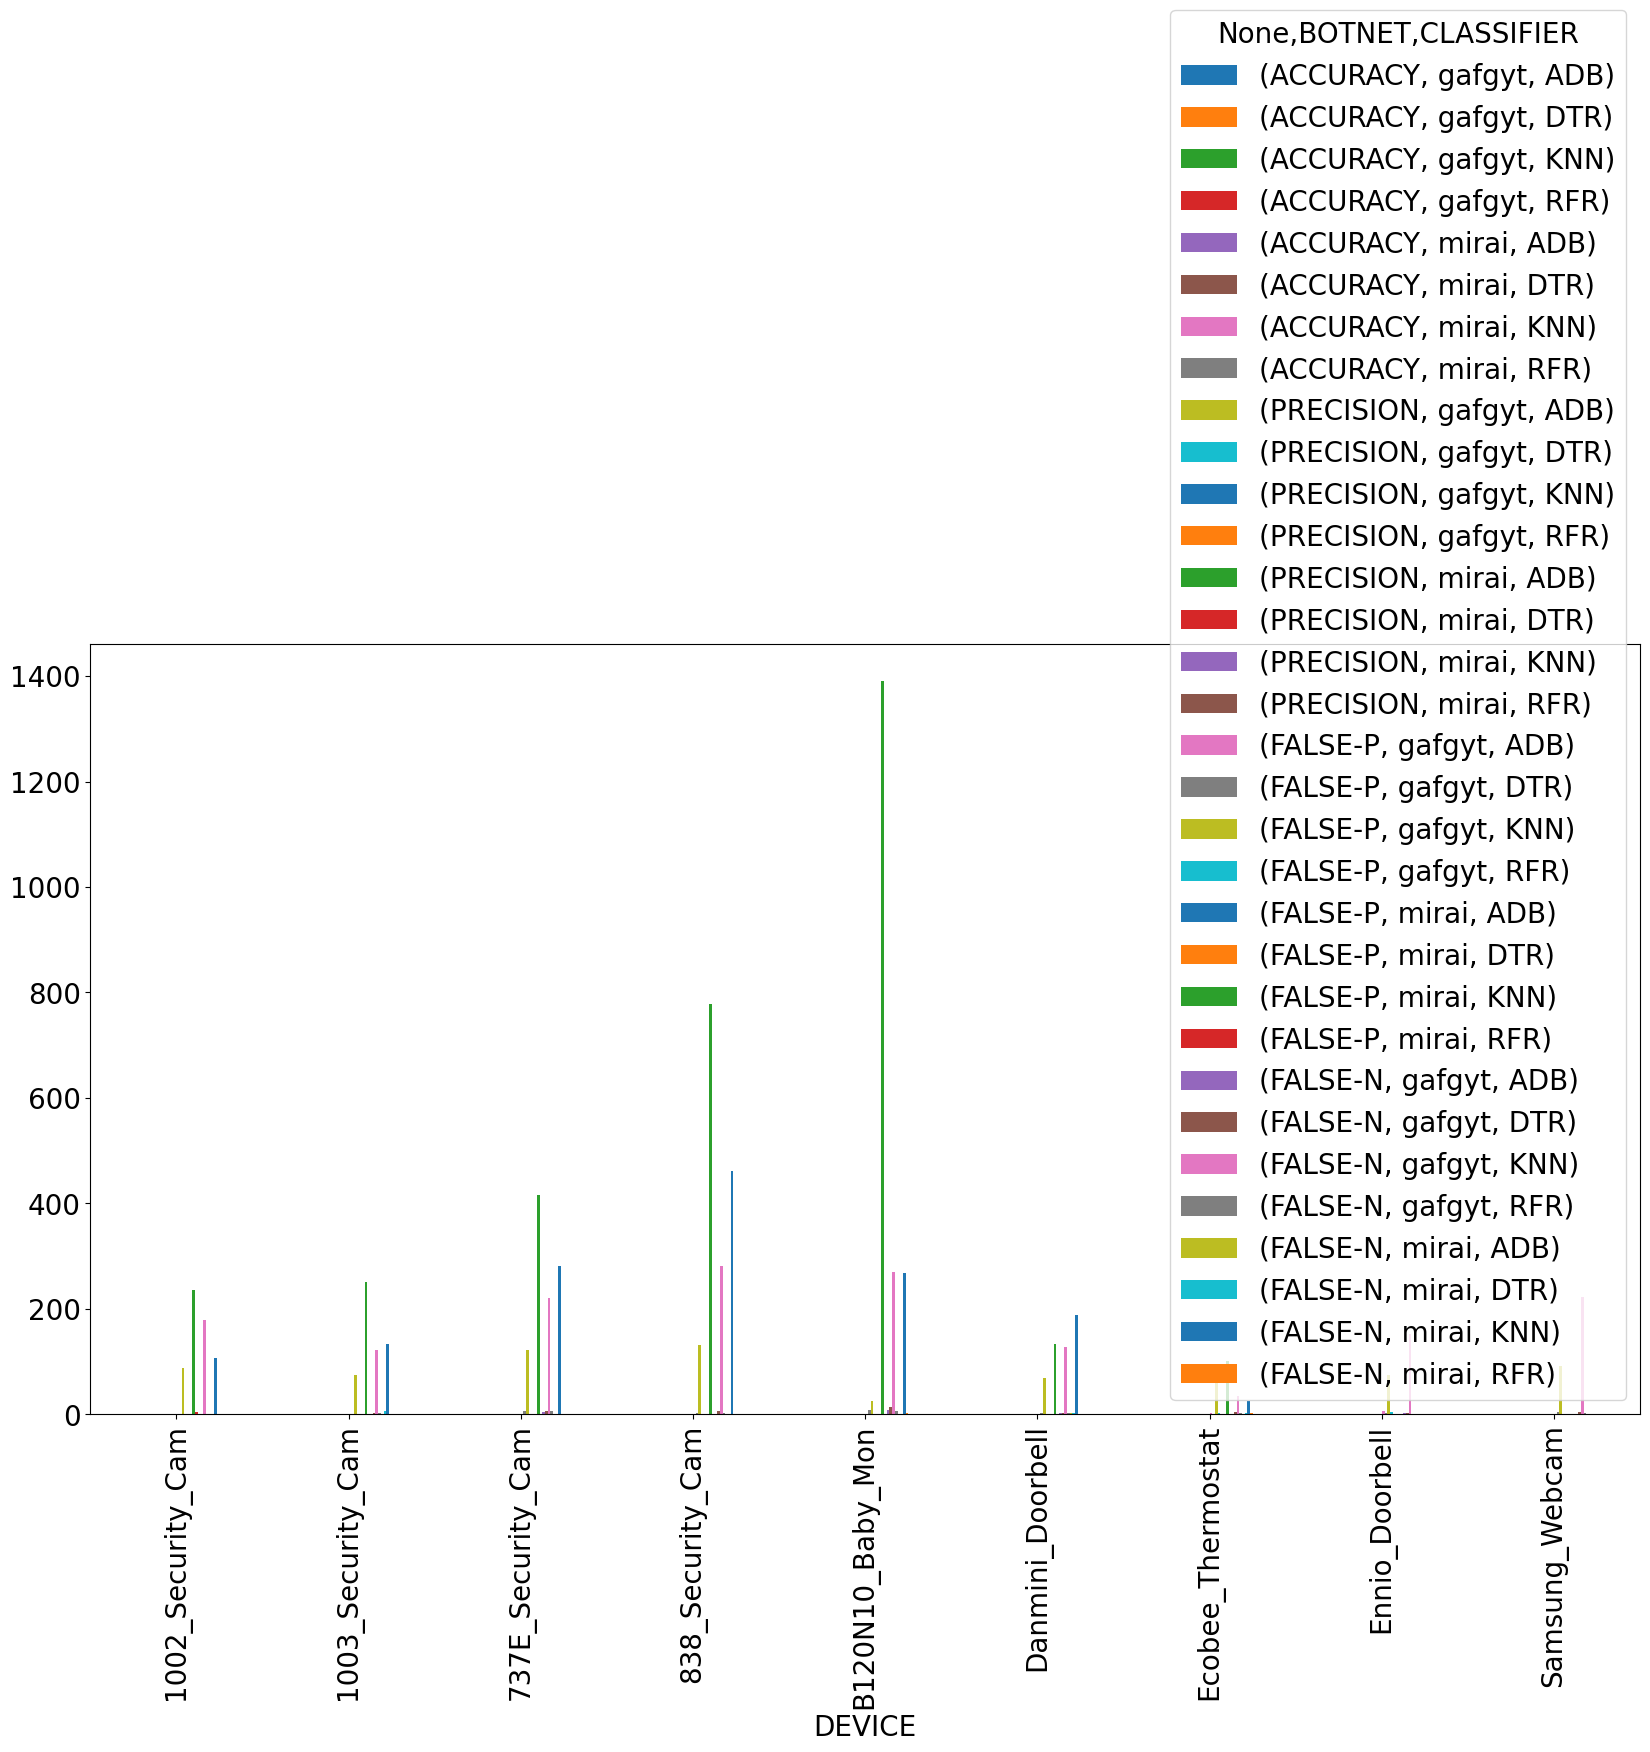

In [22]:
res_df1.plot(kind='bar')

In [1]:
import matplotlib.pyplot as plt


NameError: name 'res_df1' is not defined

TypeError: 'locator' must be an instance of matplotlib.ticker.Locator, not a matplotlib.ticker.ScalarFormatter

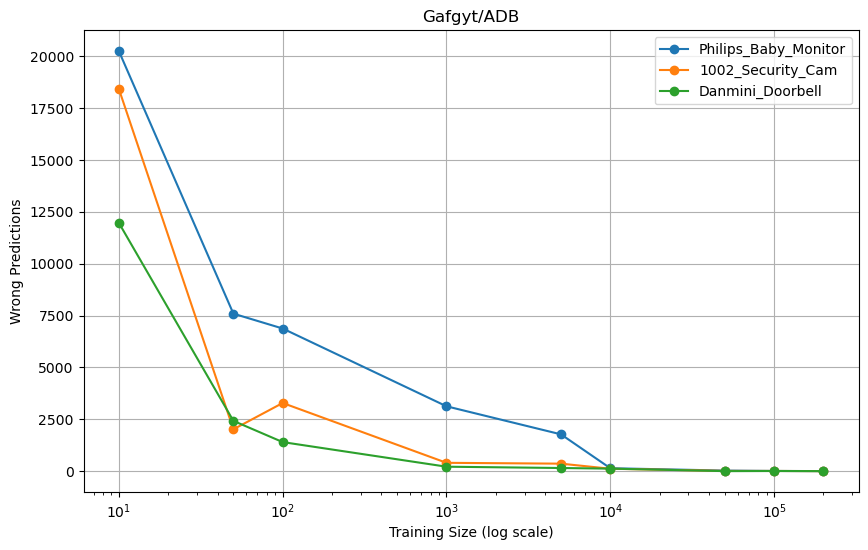

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Sample data (replace this with your actual data)
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Data for each device
data_philips = [20244, 7590, 6873, 3125, 1772, 140, 27, 8, 1]
data_security = [18418, 2016, 3284, 400, 360, 115, 11, 8, 0]
data_danmini = [11965, 2422, 1399, 213, 150, 120, 0, 6, 0]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})  # Adjust the font size for the whole graph

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis to logarithmic scale
plt.xscale('log')

# Customize the graph
plt.xlabel('Training Size (log scale)')
plt.ylabel('Wrong Predictions')
plt.title('Gafgyt/ADB')
plt.grid(True)
plt.legend()

# Use ScalarFormatter to force non-scientific notation for x-axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(ScalarFormatter())

# Customize y-axis ticks
y_ticks = [10, 100, 1000, 10000, 100000, 1000000]
plt.yticks(y_ticks)

# Show the graph
plt.show()


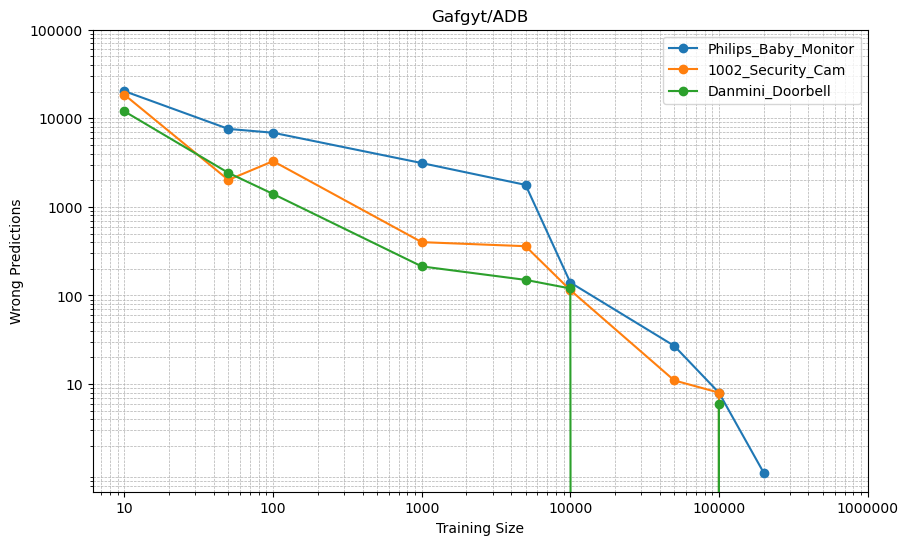

In [45]:
import matplotlib.pyplot as plt

# Sample data
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Data for each device
data_philips = [20244, 7590, 6873, 3125, 1772, 140, 27, 8, 1]
data_security = [18418, 2016, 3284, 400, 360, 115, 11, 8, 0]
data_danmini = [11965, 2422, 1399, 213, 150, 120, 0, 6, 0]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})  # Adjust the font size for the whole graph

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Gafgyt/ADB')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


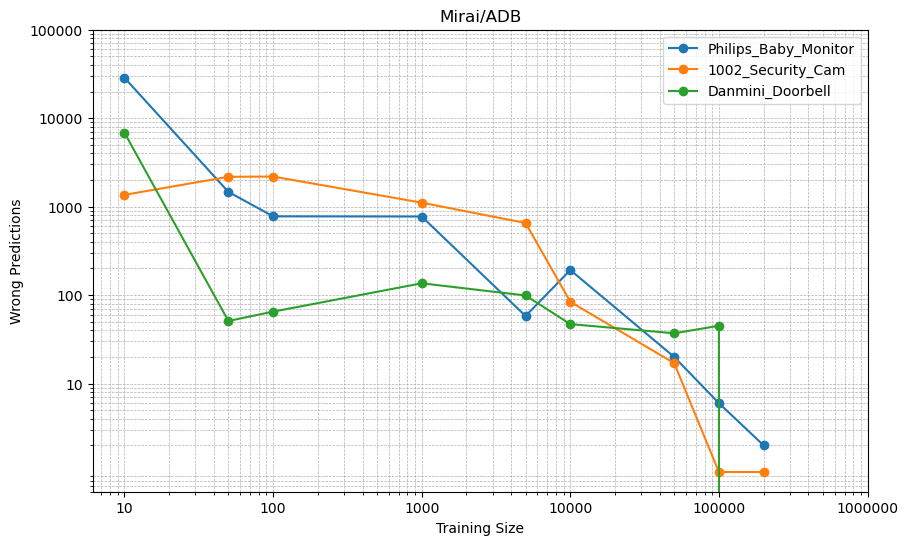

In [44]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_philips = [28619, 1468, 777, 773, 58, 192, 20, 6, 2]
data_security = [1359, 2173, 2189, 1109, 653, 84, 17, 1, 1]
data_danmini = [6844, 51, 65, 136, 99, 47, 37, 45, 0]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Mirai/ADB')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


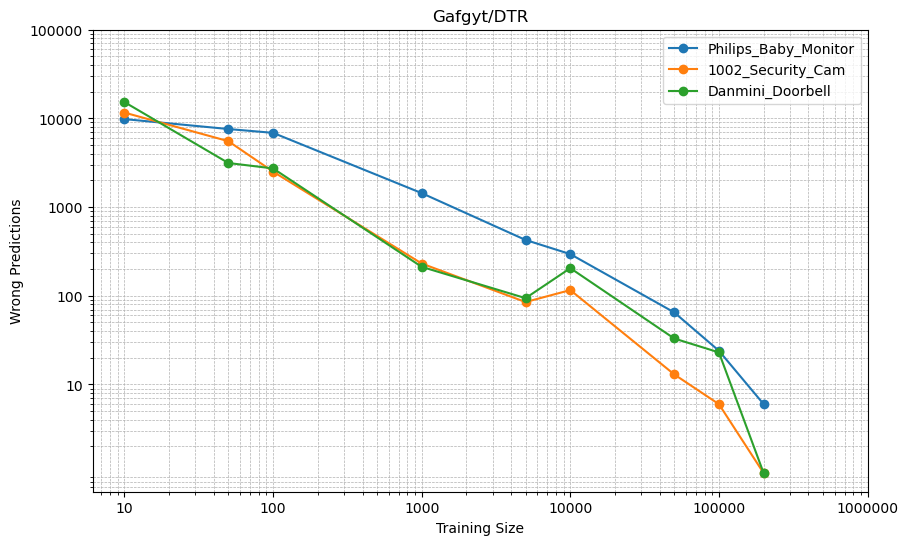

In [47]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_philips = [9824, 7590, 6873, 1437, 426, 295, 65, 24, 6]
data_security = [11627, 5537, 2511, 231, 85, 116, 13, 6, 1]
data_danmini = [15265, 3141, 2729, 212, 94, 205, 33, 23, 1]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Gafgyt/DTR')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


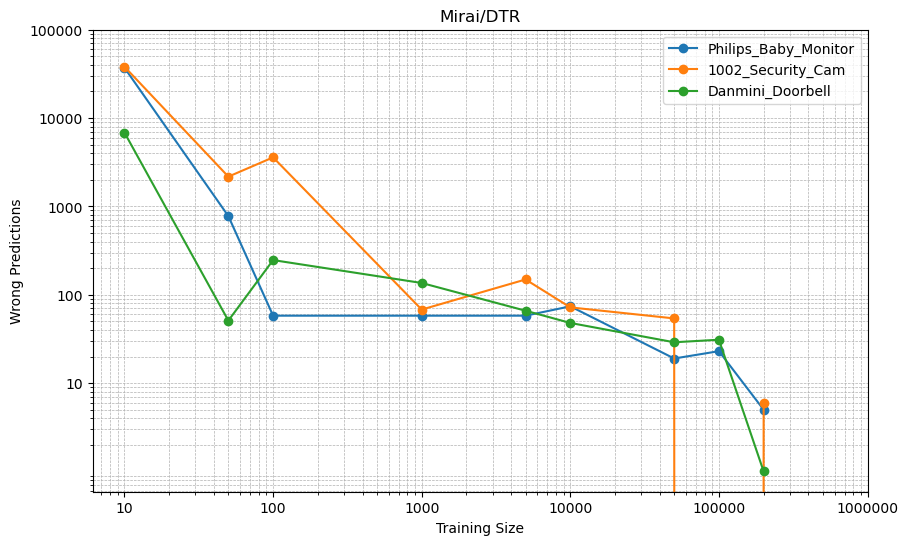

In [48]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_philips = [37095, 777, 58, 58, 58, 74, 19, 23, 5]
data_security = [38113, 2173, 3591, 68, 149, 72, 54, 0, 6]
data_danmini = [6844, 51, 247, 136, 66, 48, 29, 31, 1]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Mirai/DTR')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


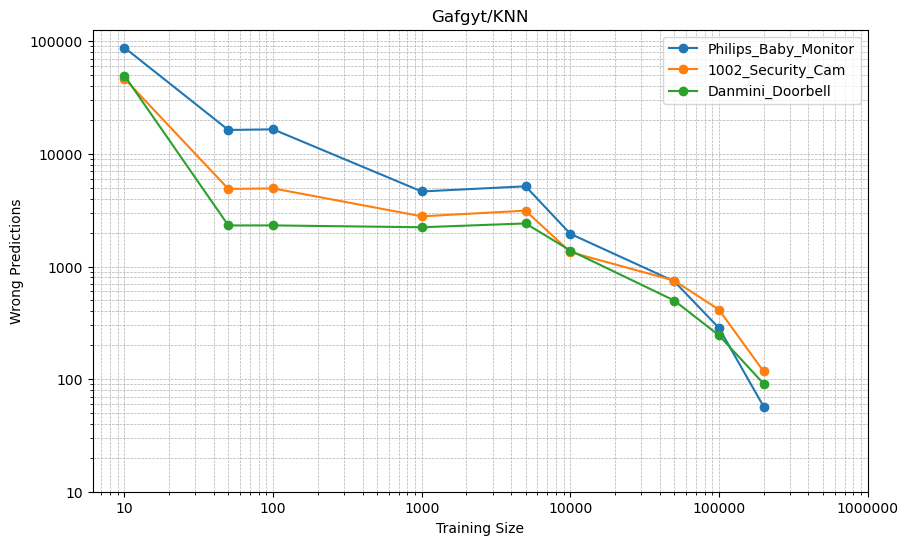

In [50]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_philips = [87808, 16316, 16534, 4640, 5158, 1951, 739, 285, 57]
data_security = [46583, 4886, 4941, 2791, 3134, 1342, 750, 414, 117]
data_danmini = [49546, 2316, 2318, 2232, 2413, 1387, 499, 245, 91]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Gafgyt/KNN')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


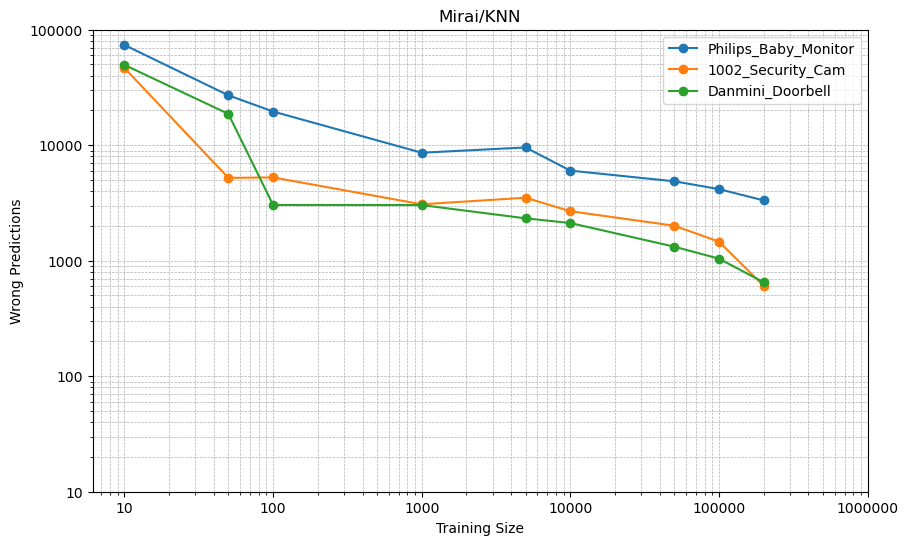

In [51]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["Philips_Baby_Monitor", "1002_Security_Cam", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_philips = [73721, 27051, 19576, 8612, 9565, 6025, 4872, 4171, 3328]
data_security = [46584, 5214, 5265, 3080, 3512, 2683, 2010, 1464, 606]
data_danmini = [49547, 18675, 3040, 3033, 2328, 2120, 1324, 1042, 651]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_philips, data_security, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Mirai/KNN')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


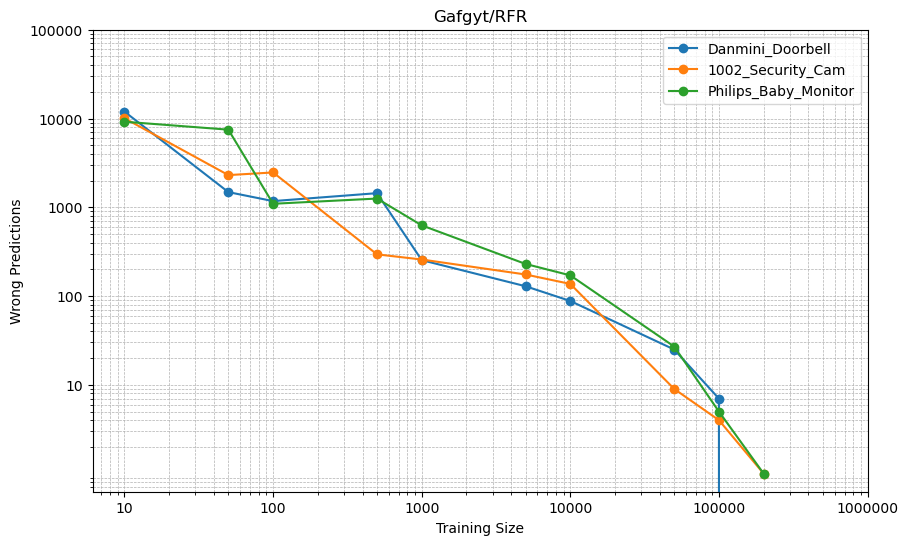

In [52]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["Danmini_Doorbell", "1002_Security_Cam", "Philips_Baby_Monitor"]
train_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_danmini = [11949, 1482, 1174, 1442, 254, 129, 88, 25, 7, 0]
data_security = [10069, 2304, 2468, 295, 258, 175, 137, 9, 4, 1]
data_philips = [9198, 7486, 1095, 1254, 626, 230, 171, 27, 5, 1]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_danmini, data_security, data_philips]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Gafgyt/RFR')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()


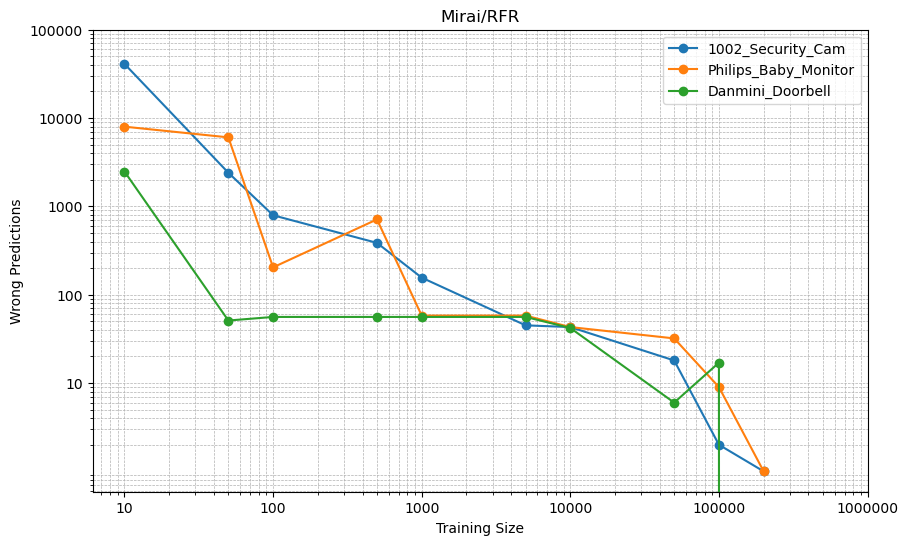

In [53]:
import matplotlib.pyplot as plt

# Devices and training sizes
devices = ["1002_Security_Cam", "Philips_Baby_Monitor", "Danmini_Doorbell"]
train_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 200000]

# Organized data for each device from the new dataset
data_security = [41022, 2403, 793, 386, 156, 45, 43, 18, 2, 1]
data_philips = [7988, 6043, 204, 712, 58, 58, 43, 32, 9, 1]
data_danmini = [2479, 51, 56, 56, 56, 56, 42, 6, 17, 0]

# Create the graph with a smaller font size
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})

for device, data in zip(devices, [data_security, data_philips, data_danmini]):
    plt.plot(train_sizes, data, marker='o', label=device)

# Set x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Customize the graph
plt.xlabel('Training Size')
plt.ylabel('Wrong Predictions')
plt.title('Mirai/RFR')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Set x-axis and y-axis ticks
x_ticks = [10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [10,  100, 1000, 10000, 100000]
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_ticks)

# Show the graph
plt.show()
